In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares


# 1. MARKET CURVE (CCIL Zero Curve 25-Nov-2025)
maturities = np.array([0.5, 1.0, 1.5, 2.0, 2.5])   # in years
zero_rates_percent = np.array([5.47, 5.56, 5.64, 5.72, 5.81])  # in %
zero_rates = zero_rates_percent / 100.0

def zero_rates_to_discount(T, r):
    return np.exp(-r * T)

market_discounts = zero_rates_to_discount(maturities, zero_rates)


# 2. HO-LEE MODEL FUNCTIONS


def simulate_ho_lee(theta, sigma, r0, dt, n_steps, n_paths, seed=None):
    rng = np.random.default_rng(seed)
    r = np.zeros((n_paths, n_steps+1))
    r[:, 0] = r0
    sqrt_dt = np.sqrt(dt)

    for t in range(n_steps):
        eps = rng.standard_normal(n_paths)
        r[:, t+1] = r[:, t] + theta[t]*dt + sigma*sqrt_dt*eps

    return r

def price_zero_coupon_mc(theta, sigma, r0, dt, n_steps, n_paths, T_index, seed=None):
    r_paths = simulate_ho_lee(theta, sigma, r0, dt, n_steps, n_paths, seed)
    integral_r = np.sum(r_paths[:, :T_index] * dt, axis=1)
    return np.mean(np.exp(-integral_r))


# 3. CALIBRATION ENGINE


def calibrate_theta(mkt_T, mkt_P, sigma, r0, dt, n_steps, n_paths, seed=123):
    indices = [int(round(T / dt)) for T in mkt_T]
    theta0 = np.zeros(n_steps)

    def residual(theta):
        res = []
        for i, idx in enumerate(indices):
            P_model = price_zero_coupon_mc(theta, sigma, r0, dt, n_steps,
                                           n_paths, idx, seed + i)
            res.append(P_model - mkt_P[i])
        return np.array(res)

    result = least_squares(residual, theta0, max_nfev=30)
    return result.x, result


# 4. RUN CALIBRATION USING MARKET DATA


dt = 0.25         # quarterly grid
T_max = 3.0
n_steps = int(T_max / dt)

sigma = 0.01       # interest-rate volatility assumption
r0 = zero_rates[0] # short rate = 6m zero rate
n_paths = 6000

theta_calibrated, result = calibrate_theta(
    maturities, market_discounts,
    sigma, r0,
    dt, n_steps,
    n_paths
)


# 5. OUTPUT RESULTS


print("Calibrated theta(t):")
for t, th in enumerate(theta_calibrated):
    print(f"t={t*dt:.2f} yrs -> theta = {th:.6f}")

# Compare market vs model discount factors
model_prices = []
indices = [int(round(T/dt)) for T in maturities]
for i, idx in enumerate(indices):
    pm = price_zero_coupon_mc(theta_calibrated, sigma, r0, dt, n_steps,
                              n_paths, idx, seed=999+i)
    model_prices.append(pm)

df = pd.DataFrame({
    "Maturity (yrs)": maturities,
    "Market Zero Rate (%)": zero_rates_percent,
    "Market P(0,T)": market_discounts,
    "Model P(0,T)": model_prices
})

print("\nCalibration Fit:")
print(df)



Calibrated theta(t):
t=0.00 yrs -> theta = -0.000176
t=0.25 yrs -> theta = 0.004402
t=0.50 yrs -> theta = 0.004667
t=0.75 yrs -> theta = 0.004931
t=1.00 yrs -> theta = 0.003141
t=1.25 yrs -> theta = 0.001351
t=1.50 yrs -> theta = 0.002554
t=1.75 yrs -> theta = 0.003757
t=2.00 yrs -> theta = 0.001878
t=2.25 yrs -> theta = 0.000000
t=2.50 yrs -> theta = 0.000000
t=2.75 yrs -> theta = 0.000000

Calibration Fit:
   Maturity (yrs)  Market Zero Rate (%)  Market P(0,T)  Model P(0,T)
0             0.5                  5.47       0.973021      0.973020
1             1.0                  5.56       0.945917      0.946086
2             1.5                  5.64       0.918880      0.918623
3             2.0                  5.72       0.891901      0.891981
4             2.5                  5.81       0.864806      0.865502


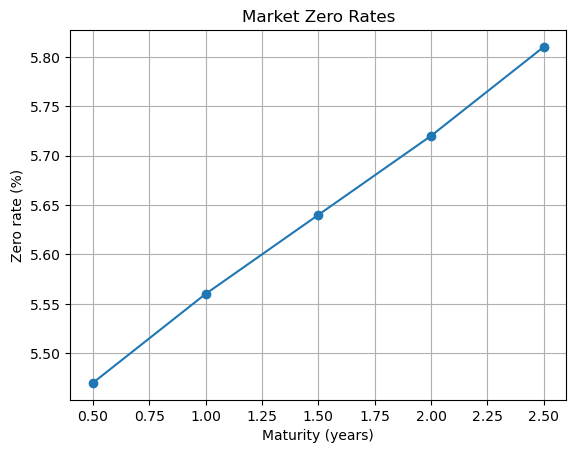

In [2]:
import matplotlib.pyplot as plt
plt.plot(maturities, zero_rates_percent, marker='o')
plt.xlabel('Maturity (years)'); plt.ylabel('Zero rate (%)')
plt.title('Market Zero Rates'); plt.grid(True)
plt.show()
